## Final Capstone

For this final capstone project for the Thinkful Data Science Bootcamp, I will be exploring data related to Major League Baseball (MLB) attendance from 2016-2017. I will scrape data from www.baseball-reference.com in attempt to predict attendance for future games. This information would be extremely useful to MLB teams, as well as their supplier companies.

In [552]:
#Import necessary modules

import requests
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics as stat
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import ensemble
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth


%matplotlib inline

## Scrape Data, Conduct General Cleaning

In [553]:
#Create list of teams in order to run our loop on baseball-reference.com

teams = ['ARI', 'ATL', 'BAL', 'BOS', 'CHC', 'CHW', 'CIN',
        'CLE', 'COL', 'DET', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA',
        'MIL', 'MIN', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP',
        'SEA', 'SFG', 'STL', 'TBR', 'TEX', 'TOR', 'WSN']

In [554]:
#Create empty dataframe to append onto after each run
team_df = pd.DataFrame()

#Set our list of columns to be added at the end
columns_list = ['day', 'date', 'box_score', 'team', 'home_away', 'opponent', 'WL', 'runs', 'runs_against',
            'innings', 'record', 'division_rank', 'GB', 'winning_pitcher', 'losing_pitcher',
            'save_pitcher', 'time', 'day_night', 'attendance_1', 'attendance_2', 'streak', 'original', 'year_num']
    
#Make a pass for each team, for each year
for team in teams:
    for year in range(2016, 2018):
        try:
            html = requests.get('http://www.baseball-reference.com/teams/' + team + '/' + str(year) +
                                '-schedule-scores.shtml')
            bs = BeautifulSoup(html.text, 'html.parser')
            trows = bs.find('table', {'class':'stats_table'}).find_all('tr')
            results = []
            for trow in trows:
                cells = trow.find_all('td')
                str_cells = str(cells)
                cleantext = BeautifulSoup(str_cells, 'html.parser').get_text()
                results.append(cleantext + ',' + str(year))
            df = pd.DataFrame(results)
            team_df = team_df.append(df, ignore_index=True)

        except:
            pass
    
#Clean our final dataframe
team_df = team_df[0].str.split(',', expand=True) #split beautiful soup elements into each cell
team_df[0] = team_df[0].str.strip('[') #remove front bracket
team_df.iloc[:,-2] = team_df.iloc[:,-2].str.strip(']') #remove end backet
team_df.columns = columns_list #set out column names
team_df = team_df.iloc[1:] #remove first blank row
team_df = team_df.drop(['box_score', 'innings', 'original', 'save_pitcher'], 1) #drop unnecessary columns
team_df['attendance'] = team_df['attendance_1'].astype(str) + team_df['attendance_2'].astype(str) #concatenating attendance columns that were separated
team_df['attendance'] = pd.to_numeric(team_df['attendance'], errors='coerce') #convert new attendance column to int
team_df = team_df.drop(['attendance_1', 'attendance_2'], 1) #now drop unnecessary attendance columns after conversion
team_df['win'], team_df['loss'] = team_df['record'].str.split('-', 1).str #split record into win/loss (temporary)
team_df['win'] = pd.to_numeric(team_df['win'], errors='coerce') #convert win to int
team_df['loss'] = pd.to_numeric(team_df['loss'], errors='coerce') #convert loss to int
team_df['win_percentage'] = round(team_df['win']/(team_df['win'] + team_df['loss']), 2) #create win percentage column
team_df = team_df.drop(['win', 'loss', 'record'], 1) #now drop unnecessary win/loss/record after creating win percentage

#Get a feel for our dataframe
pd.options.display.max_columns = 30
print("Shape of Dataframe is {}".format(team_df.shape))
display(team_df.head(10))
print(team_df.dtypes)

Shape of Dataframe is (10195, 18)


,day,date,team,home_away,opponent,WL,runs,runs_against,division_rank,GB,winning_pitcher,losing_pitcher,time,day_night,streak,year_num,attendance,win_percentage
1,Monday,Apr 4,ARI,,COL,L,5,10,4,1.0,Miller,Greinke,4:11,N,-,2016,48165.0,0.00
2,Tuesday,Apr 5,ARI,,COL,W,11,6,3,1.0,Clippard,Bergman,3:14,N,+,2016,21830.0,0.50
3,Wednesday,Apr 6,ARI,,COL,L,3,4,4,2.0,Chatwood,Corbin,2:39,D,-,2016,18572.0,0.33
4,Thursday,Apr 7,ARI,,CHC,L,6,14,4,2.0,Lackey,De La Rosa,3:29,N,--,2016,24656.0,0.25
5,Friday,Apr 8,ARI,,CHC,W-wo,3,2,4,2.0,Ziegler,Cahill,2:48,N,+,2016,27539.0,0.40
6,Saturday,Apr 9,ARI,,CHC,L,2,4,5,2.0,Hendricks,Greinke,2:46,N,-,2016,32185.0,0.33
7,Sunday,Apr 10,ARI,,CHC,L,3,7,5,3.0,Arrieta,Miller,3:21,D,--,2016,33258.0,0.29
8,Tuesday,Apr 12,ARI,@,LAD,W,4,2,4,3.0,Clippard,Hatcher,3:00,D,+,2016,53279.0,0.38
9,Wednesday,Apr 13,ARI,@,LAD,L,1,3,4,3.0,Wood,De La Rosa,3:12,N,-,2016,44244.0,0.33
10,Thursday,Apr 14,ARI,@,LAD,L,2,5,4,3.0,Howell,Delgado,2:36,N,--,2016,40879.0,0.30


day                 object
date                object
team                object
home_away           object
opponent            object
WL                  object
runs                object
runs_against        object
division_rank       object
GB                  object
winning_pitcher     object
losing_pitcher      object
time                object
day_night           object
streak              object
year_num            object
attendance         float64
win_percentage     float64
dtype: object


## Further Data Cleaning, Preliminary Feature Engineering

In [555]:
#Remove white space
for col in team_df.columns:
    team_df[col] = team_df[col].astype(str)
    team_df[col] = team_df[col].str.strip()

In [556]:
#Filter out away games
team_df = team_df.loc[team_df['home_away'] == '']

In [557]:
#Recreate WL groupings
team_df['WL'].replace(['L', 'W', 'W-wo', 'L-wo', 'None', 'T', 'W &H;', 'W &V;', 'L &V;', 'L &H;'],
                      ['L', 'W', 'W', 'L', 'None', 'T', 'W', 'W', 'L', 'L'], inplace=True)

In [558]:
#Remove None from WL
team_df = team_df.loc[team_df['WL'] != 'None']

In [559]:
#Turn day_night into indicator (day = 1, night = 0)
team_df['day_night'] = np.where((team_df['day_night'] == 'D'), 1, 0)

In [560]:
#Understand unique streak values
team_df.streak.unique()

array(['-', '+', '--', '---', '----', '-----', '++', '+++', '------',
       '++++', '+++++', '++++++', '+++++++', '-------', '++++++++',
       '+++++++++', '++++++++++', '+++++++++++', ']', '--------',
       '---------', '++++++++++++++++', '+++++++++++++++++',
       '++++++++++++++++++', '+++++++++++++++++++',
       '++++++++++++++++++++', '+++++++++++++++++++++',
       '++++++++++++++++++++++', '-----------', '----------'],
      dtype=object)

In [561]:
#Streak function

def streak(x):
    x_streak = str(x)
    x_streak = list(x_streak)
    counter = 0
    if x_streak[0] == '-':
        for i in x_streak:
            counter += 1
            final = '-' + str(counter)
            final = int(final)
    else:
        for i in x_streak:
            counter += 1
            final = '+' + str(counter)
            final = int(final)
    return final

In [562]:
#Apply streak function to streak column
team_df['streak'] = team_df['streak'].apply(streak)

In [563]:
#Confirm this worked
team_df['streak'].head(5)

1   -1
2    1
3   -1
4   -2
5    1
Name: streak, dtype: int64

In [564]:
#Deal with GB column
team_df['GB'].unique()

array(['1.0', '2.0', '3.0', '1.5', '2.5', '0.5', '4.0', '5.0', '4.5',
       '5.5', '9.0', '10.0', '10.5', '9.5', '11.5', '12.5', '13.5',
       '15.0', '14.0', '16.0', '19.0', '18.0', '17.0', '18.5', '17.5',
       '21.0', '22.0', '20.0', '24.0', '23.0', 'up 0.5', 'Tied', 'up 1.0',
       '3.5', '6.5', '7.5', '6.0', '7.0', '8.0', '12.0', '16.5', '19.5',
       '20.5', '21.5', '23.5', '24.5', '25.0', '25.5', '26.5', '27.5',
       '28.5', '29.5', '28.0', '29.0', '30.0', '31.0', '32.0', '11.0',
       '14.5', '22.5', 'up 1.5', 'up 2.0', 'up 2.5', 'up 3.5', 'up 3.0',
       'up 4.0', '8.5', '15.5', 'up 5.0', 'up 4.5', 'up 6.5', 'up 7.5',
       'up 8.5', 'up 7.0', 'up 8.0', 'up 9.0', 'up 5.5', 'up 9.5',
       'up10.5', 'up11.5', 'up12.5', 'up12.0', 'up13.0', 'up14.0',
       'up15.0', 'up15.5', 'up16.5', 'up17.0', 'up18.0', 'up16.0', '13.0',
       '30.5', '33.5', '34.5', '34.0', '26.0', '27.0', '31.5', '35.5',
       'up 6.0', 'up11.0', 'up13.5', 'up14.5', '33.0', '35.0', '36.0',
     

In [565]:
#Create function to convert GB

def gb(x):
    x = x.replace(" ", "")
    if x[0] == 'u':
        x = x[2:]
        x = float(x)

    elif x[0].isdigit() == True:
        x = '-' + x
        x = float(x)
    
    else:
        x = 0
        
    return x

In [566]:
#Apply function to GB column
team_df['GB'] = team_df['GB'].apply(gb)

In [567]:
#Clean date column, first create function
import re
def remove_parentheses(i):
    i = str(i)
    i = re.sub(r'\([^)]*\)', '', i)
    return i

In [568]:
#Apply it to date column
team_df['date'] = team_df['date'].apply(remove_parentheses)

In [569]:
#Strip whitespace again after removing parentheses data
team_df['date'] = team_df['date'].str.strip()

In [570]:
#Convert date into month and day
team_df['month_num'], team_df['day_num'] = team_df['date'].str.split(' ', 1).str

In [571]:
#Recreate month_num groupings
team_df['month_num'].replace(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'],
                      [4, 5, 6, 7, 8, 9, 10], inplace=True)

In [572]:
#Deal with null values
missing_values_count = team_df.isnull().sum()
print(missing_values_count)

day                0
date               0
team               0
home_away          0
opponent           0
WL                 0
runs               0
runs_against       0
division_rank      0
GB                 0
winning_pitcher    0
losing_pitcher     0
time               0
day_night          0
streak             0
year_num           0
attendance         0
win_percentage     0
month_num          0
day_num            0
dtype: int64


In [573]:
#Do pd.datetime on all date related columns
team_df = team_df.loc[team_df['year_num'] != 'None']

team_df['month_num'] = team_df['month_num'].astype(int)
team_df['day_num'] = team_df['day_num'].astype(int)
team_df['year_num'] = team_df['year_num'].astype(int)

In [574]:
#Create standardized date column
team_df['actual_date'] = pd.to_datetime(team_df.year_num*10000+team_df.month_num*100+team_df.day_num,format='%Y%m%d')

In [575]:
#Final removal of columns - date, home_away
team_df = team_df.drop(['date', 'home_away'], 1)

In [576]:
#Convert time of game column - first create function

def convert_game_time(x):
    x = str(x)
    i, j = x.split(':')
    i, j = int(i), int(j)
    x = (i*60) + (j)
    return x

In [577]:
#Apply function to time column
team_df['time'] = team_df['time'].apply(convert_game_time)

In [578]:
#Convert all data types to appropriate ones - first take a look at our datatypes
team_df.dtypes

day                        object
team                       object
opponent                   object
WL                         object
runs                       object
runs_against               object
division_rank              object
GB                        float64
winning_pitcher            object
losing_pitcher             object
time                        int64
day_night                   int64
streak                      int64
year_num                    int64
attendance                 object
win_percentage             object
month_num                   int64
day_num                     int64
actual_date        datetime64[ns]
dtype: object

In [579]:
#Apply conversions
team_df['win_percentage'] = team_df['win_percentage'].astype(float)
team_df['attendance'] = team_df['attendance'].astype(float)
team_df['division_rank'] = team_df['division_rank'].astype(float)
team_df['GB'] = team_df['GB'].astype(float)
team_df['runs'] = team_df['runs'].astype(int)
team_df['runs_against'] = team_df['runs_against'].astype(int)
team_df['attendance'] = team_df['attendance'].astype(int)

#Label encoders for categoricals
encoder = LabelEncoder()
team_df['day_category'] = encoder.fit_transform(team_df['day'])
team_df['team_category'] = encoder.fit_transform(team_df['team'])
team_df['opponent_category'] = encoder.fit_transform(team_df['opponent'])
team_df['WL_category'] = encoder.fit_transform(team_df['WL'])
team_df['WP_category'] = encoder.fit_transform(team_df['winning_pitcher'])
team_df['LP_category'] = encoder.fit_transform(team_df['losing_pitcher'])

In [580]:
#Add ticket price data
ticket_prices = pd.read_csv('ticket_prices.csv')

In [581]:
ticket_prices.head(10)

,team,year_num,price
0,ATL,2017,80
1,CHC,2017,130
2,STL,2017,75
3,TBD,2017,89
4,NYY,2017,117
5,LAD,2017,64
6,MIL,2017,66
7,CIN,2017,80
8,PHI,2017,60
9,HOU,2017,73


In [582]:
#Merge our dataframes (prices and team_df)

team_df = pd.merge(team_df, ticket_prices, how='inner', on=['team', 'year_num'])
display(team_df.head(10))

,day,team,opponent,WL,runs,runs_against,division_rank,GB,winning_pitcher,losing_pitcher,time,day_night,streak,year_num,attendance,win_percentage,month_num,day_num,actual_date,day_category,team_category,opponent_category,WL_category,WP_category,LP_category,price
0,Monday,ARI,COL,L,5,10,4.0,-1.0,Miller,Greinke,251,0,-1,2016,48165,0.00,4,4,2016-04-04,1,0,8,0,360,220,70
1,Tuesday,ARI,COL,W,11,6,3.0,-1.0,Clippard,Bergman,194,0,1,2016,21830,0.50,4,5,2016-04-05,5,0,8,2,107,40,70
2,Wednesday,ARI,COL,L,3,4,4.0,-2.0,Chatwood,Corbin,159,1,-1,2016,18572,0.33,4,6,2016-04-06,6,0,8,0,99,112,70
3,Thursday,ARI,CHC,L,6,14,4.0,-2.0,Lackey,De La Rosa,209,0,-2,2016,24656,0.25,4,7,2016-04-07,4,0,4,0,294,135,70
4,Friday,ARI,CHC,W,3,2,4.0,-2.0,Ziegler,Cahill,168,0,1,2016,27539,0.40,4,8,2016-04-08,0,0,4,2,603,80,70
5,Saturday,ARI,CHC,L,2,4,5.0,-2.0,Hendricks,Greinke,166,0,-1,2016,32185,0.33,4,9,2016-04-09,2,0,4,0,236,220,70
6,Sunday,ARI,CHC,L,3,7,5.0,-3.0,Arrieta,Miller,201,1,-2,2016,33258,0.29,4,10,2016-04-10,3,0,4,0,17,365,70
7,Friday,ARI,PIT,L,7,8,3.0,-1.5,Niese,Corbin,192,0,-1,2016,27829,0.50,4,22,2016-04-22,0,0,21,0,389,112,70
8,Saturday,ARI,PIT,W,7,1,2.0,-1.5,De La Rosa,Nicasio,178,0,1,2016,32935,0.53,4,23,2016-04-23,2,0,21,2,132,391,70
9,Sunday,ARI,PIT,L,10,12,2.0,-2.5,Feliz,Marshall,325,1,-1,2016,27573,0.50,4,24,2016-04-24,3,0,21,0,163,339,70


In [583]:
#Add Stadium Capacity Data
capacity = pd.read_csv('capacity.csv')

In [584]:
capacity.head(10)

,team,capacity
0,ATL,41149
1,CHC,41159
2,STL,43975
3,TBD,31042
4,NYY,47422
5,LAD,56000
6,MIL,41900
7,CIN,42319
8,PHI,43647
9,HOU,40963


In [585]:
team_df = pd.merge(team_df, capacity, how='inner', on='team')
display(team_df.head(10))

,day,team,opponent,WL,runs,runs_against,division_rank,GB,winning_pitcher,losing_pitcher,time,day_night,streak,year_num,attendance,win_percentage,month_num,day_num,actual_date,day_category,team_category,opponent_category,WL_category,WP_category,LP_category,price,capacity
0,Monday,ARI,COL,L,5,10,4.0,-1.0,Miller,Greinke,251,0,-1,2016,48165,0.00,4,4,2016-04-04,1,0,8,0,360,220,70,48633
1,Tuesday,ARI,COL,W,11,6,3.0,-1.0,Clippard,Bergman,194,0,1,2016,21830,0.50,4,5,2016-04-05,5,0,8,2,107,40,70,48633
2,Wednesday,ARI,COL,L,3,4,4.0,-2.0,Chatwood,Corbin,159,1,-1,2016,18572,0.33,4,6,2016-04-06,6,0,8,0,99,112,70,48633
3,Thursday,ARI,CHC,L,6,14,4.0,-2.0,Lackey,De La Rosa,209,0,-2,2016,24656,0.25,4,7,2016-04-07,4,0,4,0,294,135,70,48633
4,Friday,ARI,CHC,W,3,2,4.0,-2.0,Ziegler,Cahill,168,0,1,2016,27539,0.40,4,8,2016-04-08,0,0,4,2,603,80,70,48633
5,Saturday,ARI,CHC,L,2,4,5.0,-2.0,Hendricks,Greinke,166,0,-1,2016,32185,0.33,4,9,2016-04-09,2,0,4,0,236,220,70,48633
6,Sunday,ARI,CHC,L,3,7,5.0,-3.0,Arrieta,Miller,201,1,-2,2016,33258,0.29,4,10,2016-04-10,3,0,4,0,17,365,70,48633
7,Friday,ARI,PIT,L,7,8,3.0,-1.5,Niese,Corbin,192,0,-1,2016,27829,0.50,4,22,2016-04-22,0,0,21,0,389,112,70,48633
8,Saturday,ARI,PIT,W,7,1,2.0,-1.5,De La Rosa,Nicasio,178,0,1,2016,32935,0.53,4,23,2016-04-23,2,0,21,2,132,391,70,48633
9,Sunday,ARI,PIT,L,10,12,2.0,-2.5,Feliz,Marshall,325,1,-1,2016,27573,0.50,4,24,2016-04-24,3,0,21,0,163,339,70,48633


In [586]:
#For the purpose of our exploratory analysis, let's generate our attendance capacity ratio ahead of our 
#actual feature engineering section

team_df['attendance_ratio'] = round((team_df['attendance']/team_df['capacity'])*100, 2)

In [587]:
#Final look at our features and data types before exploration
team_df.dtypes

day                          object
team                         object
opponent                     object
WL                           object
runs                          int64
runs_against                  int64
division_rank               float64
GB                          float64
winning_pitcher              object
losing_pitcher               object
time                          int64
day_night                     int64
streak                        int64
year_num                      int64
attendance                    int64
win_percentage              float64
month_num                     int64
day_num                       int64
actual_date          datetime64[ns]
day_category                  int64
team_category                 int64
opponent_category             int64
WL_category                   int64
WP_category                   int64
LP_category                   int64
price                         int64
capacity                      int64
attendance_ratio            

## Exploratory Analysis

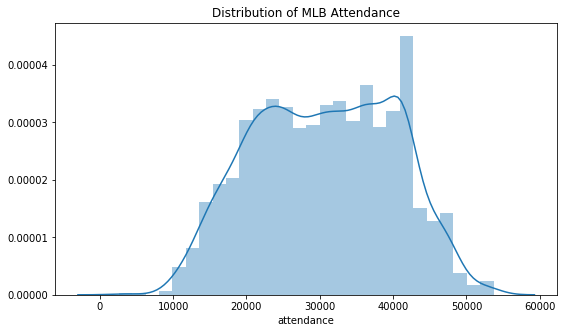

count     4683.000000
mean     30599.762759
std       9526.200855
min       2596.000000
25%      22932.500000
50%      30695.000000
75%      38387.500000
max      53701.000000
Name: attendance, dtype: float64


In [588]:
#Look at our distribution of attendance
plt.figure(figsize=[9,5])
sns.distplot(team_df['attendance'])
plt.title('Distribution of MLB Attendance')
plt.show()
print(team_df['attendance'].describe())

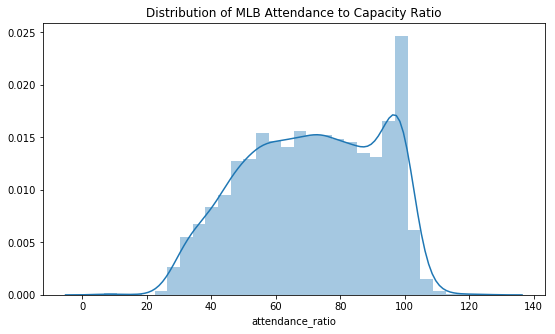

count    4683.000000
mean       71.109637
std        20.401725
min         6.770000
25%        54.985000
50%        71.980000
75%        88.690000
max       124.470000
Name: attendance_ratio, dtype: float64


In [589]:
#Look at distribution of attendance ratio
plt.figure(figsize=[9,5])
sns.distplot(team_df['attendance_ratio'])
plt.title('Distribution of MLB Attendance to Capacity Ratio')
plt.show()
print(team_df['attendance_ratio'].describe())

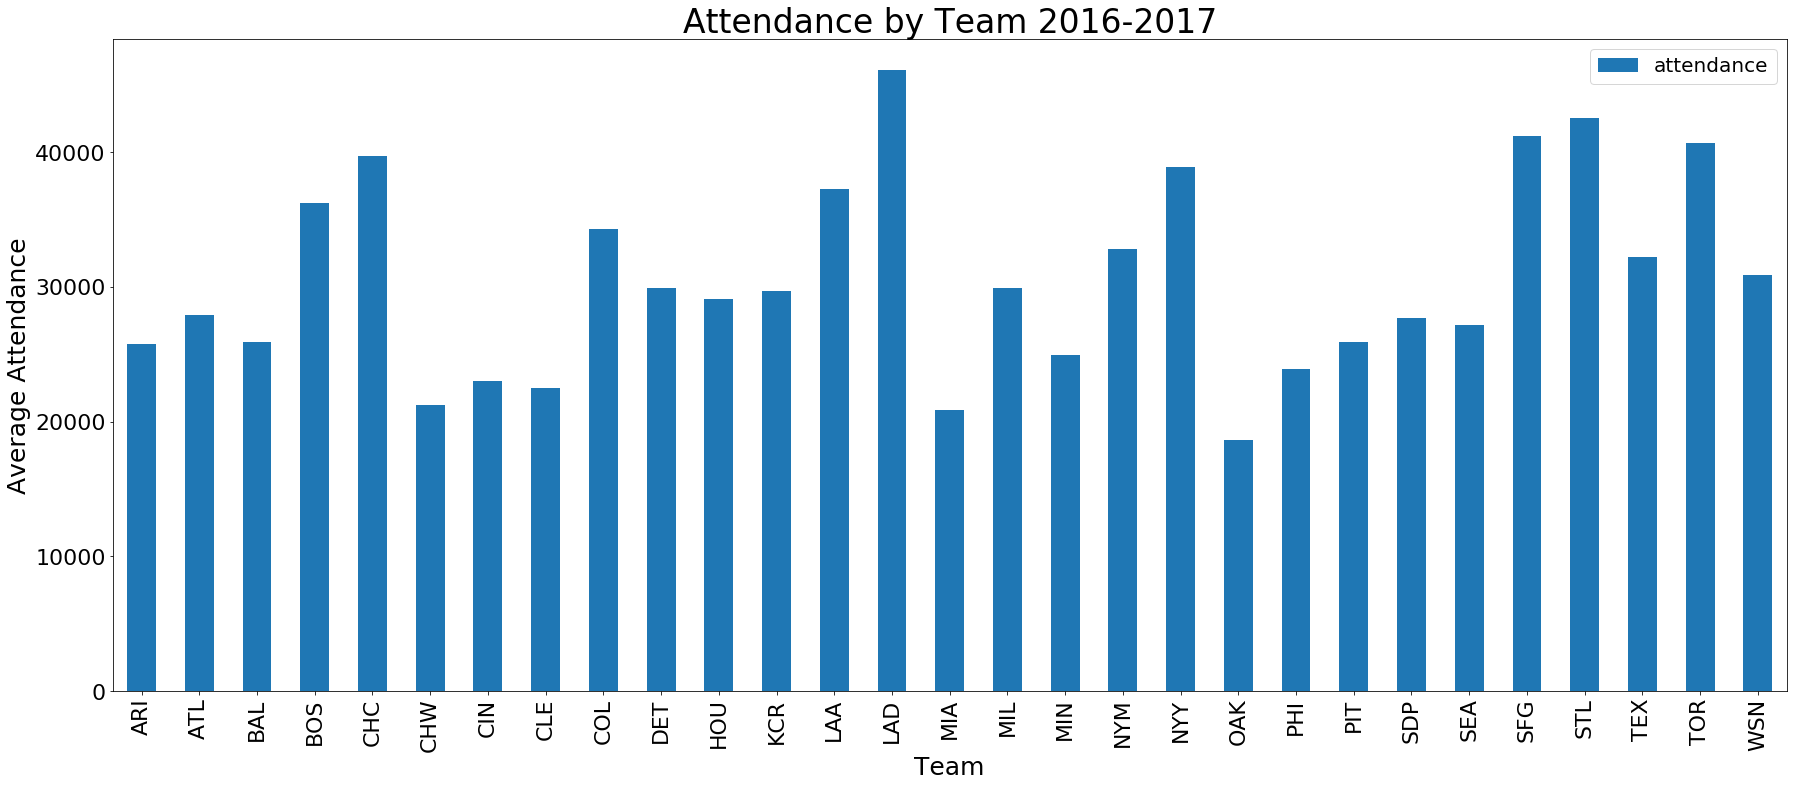

In [590]:
#Create variable for avg attendance grouped by team
attendance_team = team_df[['attendance', 'team']].groupby('team').mean()

#Set plot preferences and show plot
attendance_team.plot.bar(figsize=(30, 12))
plt.legend(fontsize=20)
plt.title('Attendance by Team 2016-2017', fontsize=33)
plt.xlabel('Team', fontsize=25)
plt.ylabel('Average Attendance', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

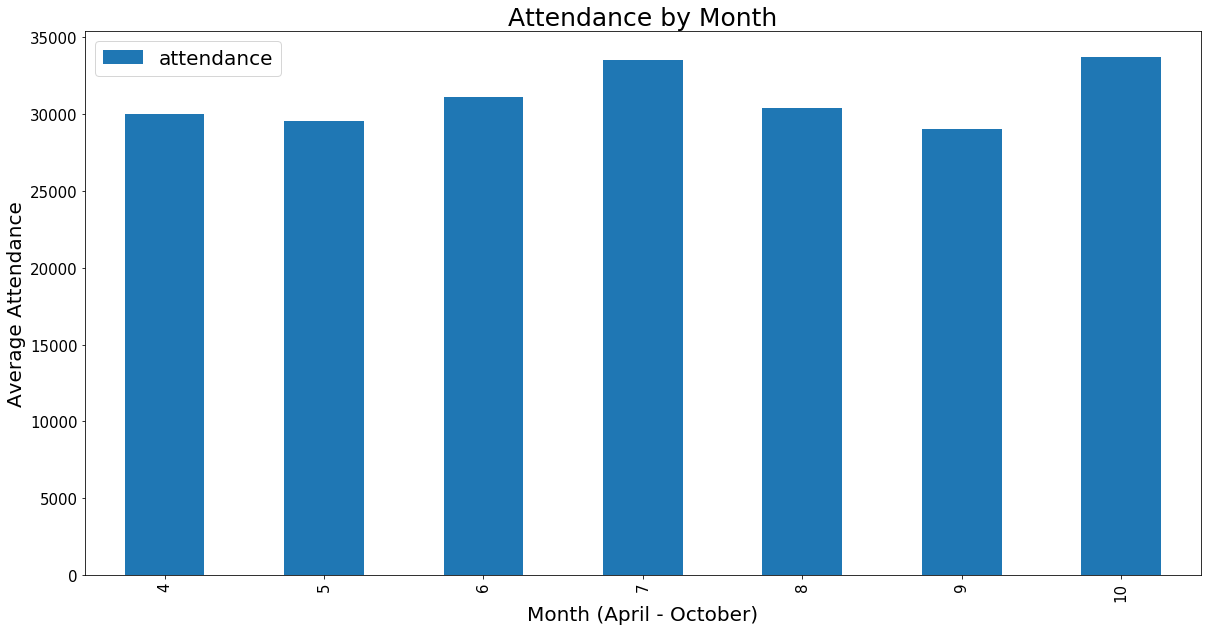

In [591]:
#Create variable for avg attendance grouped by month
attendance_month = team_df[['attendance', 'month_num']].groupby('month_num').mean()

#Set plot preferences and show plot
attendance_month.plot.bar(figsize=(20, 10))
plt.legend(fontsize=20)
plt.title('Attendance by Month', fontsize=25)
plt.xlabel('Month (April - October)', fontsize=20)
plt.ylabel('Average Attendance', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

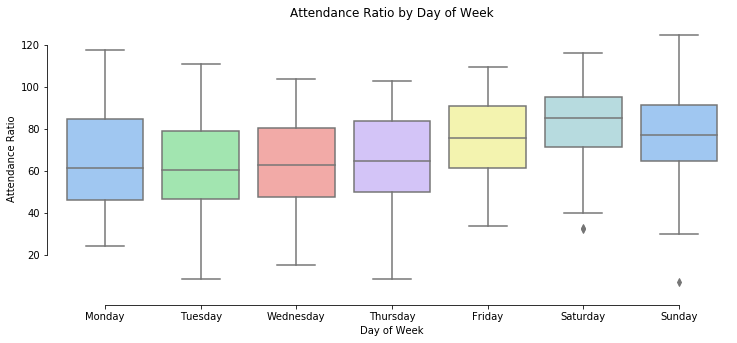

In [592]:
# Comparing attendance ratio by day of week
plt.figure(figsize=[12,5])
ax = sns.boxplot(x='day',y='attendance_ratio', data=team_df, palette='pastel')  
plt.title('Attendance Ratio by Day of Week')
sns.despine(offset=10, trim=True)
ax.set(xlabel='Day of Week', ylabel='Attendance Ratio')
plt.show()

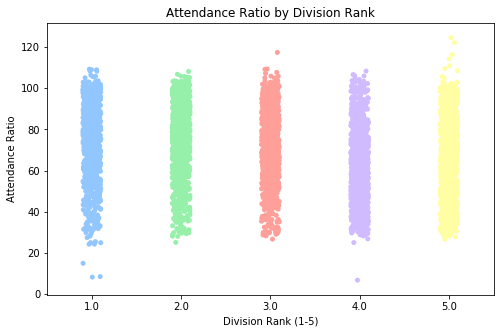

In [593]:
#Look at attendance ratio by division rank
plt.figure(figsize=[8,5])
sns.stripplot(x="division_rank", y="attendance_ratio", jitter=True, data=team_df, palette='pastel')
plt.title('Attendance Ratio by Division Rank')
plt.xlabel('Division Rank (1-5)')
plt.ylabel('Attendance Ratio')
plt.show()

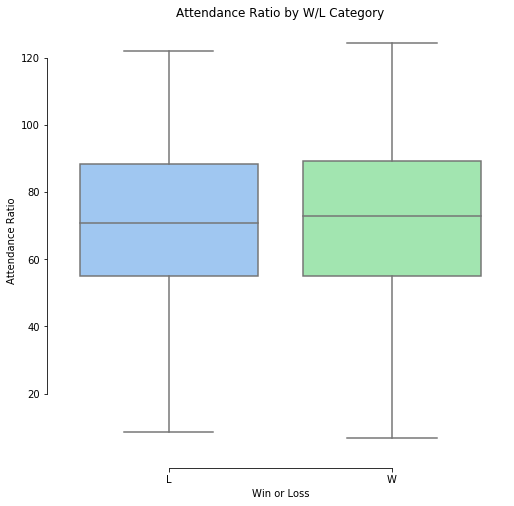

In [594]:
# Comparing attendance by win/loss/tie

team_df = team_df.loc[team_df['WL'] != 'T']

plt.figure(figsize=[8,8])
ax = sns.boxplot(x='WL', y='attendance_ratio', data=team_df, palette='pastel')  
plt.title('Attendance Ratio by W/L Category')
sns.despine(offset=10, trim=True)
ax.set(xlabel='Win or Loss', ylabel='Attendance Ratio')
plt.show()

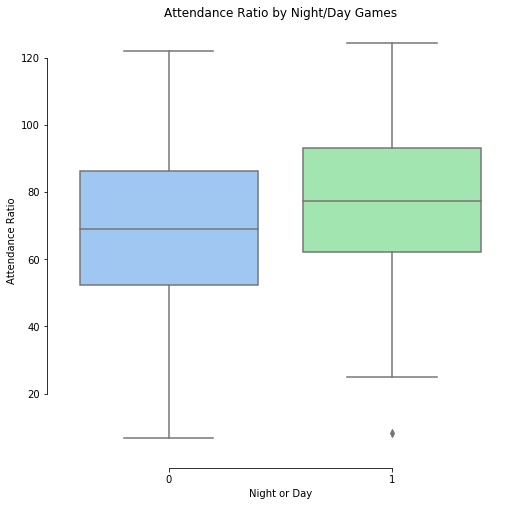

In [595]:
# Comparing attendance by day/night games
plt.figure(figsize=[8,8])
ax = sns.boxplot(x='day_night', y='attendance_ratio', data=team_df, palette='pastel')  
plt.title('Attendance Ratio by Night/Day Games')
sns.despine(offset=10, trim=True)
ax.set(xlabel='Night or Day', ylabel='Attendance Ratio')
plt.show()

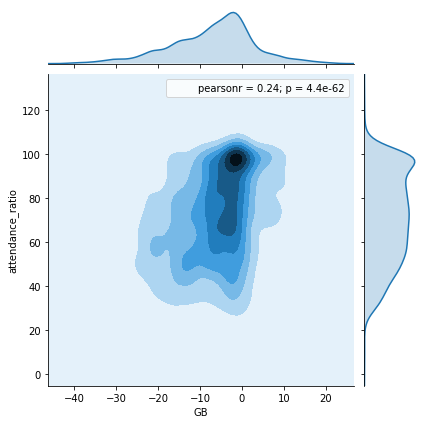

In [596]:
#Scatter plot of attendance ratio vs. GB
sns.jointplot(x='GB', y='attendance_ratio', data=team_df, kind='kde')
plt.show()

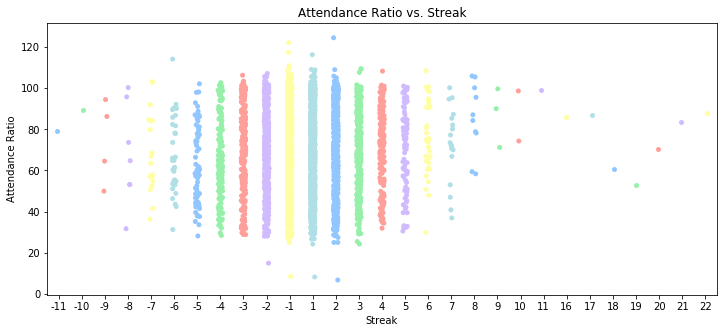

In [597]:
#Look at attendance vs. streak
plt.figure(figsize=[12,5])
sns.stripplot(x="streak", y="attendance_ratio", jitter=True, data=team_df, palette='pastel')
plt.title('Attendance Ratio vs. Streak')
plt.xlabel('Streak')
plt.ylabel('Attendance Ratio')
plt.show()

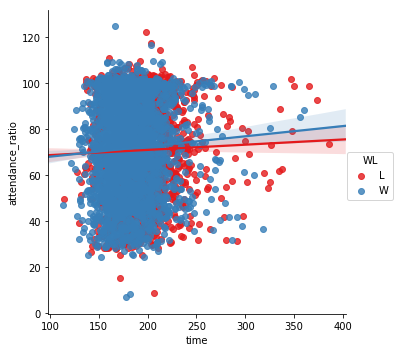

In [598]:
#Scatter plot of attendance vs. time
g = sns.lmplot(x="time", y="attendance_ratio", hue="WL", data=team_df,
               palette="Set1")

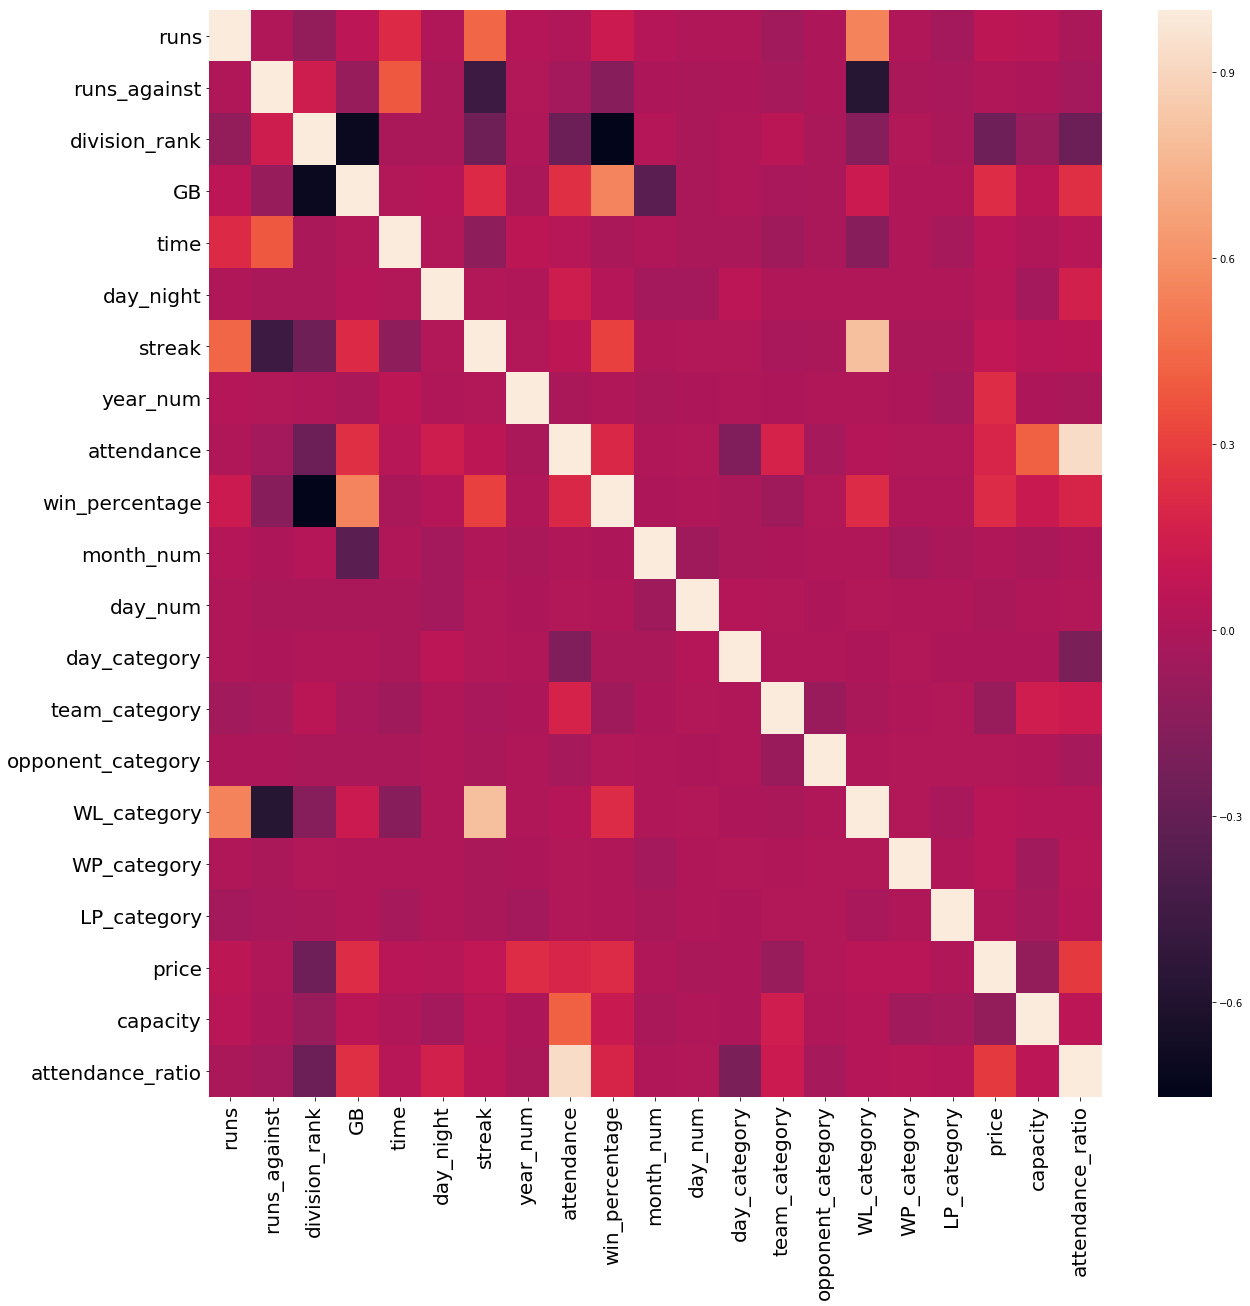

In [599]:
#Correlation matrix
f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(team_df.corr())
plt.xticks(size=20)
plt.yticks(size=20, rotation='horizontal')
plt.show()

## Feature Engineering

beginning, mid, post season indicators, streak team indicator, ticket revenue (price x attendance), removing outliers from attendance etc.

In [600]:
#Create beginning, mid, and post-season indicators
team_df['beginning_season'] = np.where((team_df['month_num'].isin([4, 5, 6])), 1, 0)
team_df['mid_season'] = np.where((team_df['month_num'].isin([7, 8, 9])), 1, 0)
team_df['post_season'] = np.where((team_df['month_num'] == 10), 1, 0)

In [601]:
#Create hot streak indicator (>= 3 games)
team_df['hot_streak'] = np.where((team_df['streak'] >= 3), 1, 0)

In [602]:
#Create ticket revenue feature (price * attendance)
team_df['average_revenue'] = team_df['attendance'] * team_df['price']

In [603]:
#Get rid of skewness/outliers in attendance
print(team_df['attendance'].quantile(0.05))

15143.55


In [604]:
#Transform attendance based on quantile method above - leave high attendance measures as we want to predict later on if they'll be above capacity
team_df = team_df[team_df['attendance'] >= 15232]

In [605]:
#Confirm this worked
print(team_df['attendance'].describe())
print(team_df['attendance_ratio'].describe())

count     4439.000000
mean     31561.270331
std       8818.776235
min      15239.000000
25%      24123.000000
50%      31660.000000
75%      38863.500000
max      53701.000000
Name: attendance, dtype: float64
count    4439.000000
mean       73.184219
std        18.839339
min        31.480000
25%        57.625000
50%        73.480000
75%        89.950000
max       124.470000
Name: attendance_ratio, dtype: float64


In [606]:
#Instantiate attendance category column
team_df['attendance_category'] = ''

In [607]:
#Establish attendance classes and assign to attendance category column (last column)

counter = 0

for i in team_df['attendance_ratio']:
    if i < 50.00:
        team_df.iloc[counter, -1] = 'Less than 50% Capacity'

    elif i >= 50.00 and i < 75.00:
        team_df.iloc[counter, -1] = 'Between 50 and 75% Capacity'
        
    elif i >= 75.00 and i < 100.00:
        team_df.iloc[counter, -1] = 'Between 75 and 100% Capacity'

    else:
        team_df.iloc[counter, -1] = 'Greater than 100% Capacity'
    
    counter += 1

In [608]:
#Confirm our function worked
team_df['attendance_category'].value_counts()

Between 75 and 100% Capacity    1849
Between 50 and 75% Capacity     1721
Less than 50% Capacity           612
Greater than 100% Capacity       257
Name: attendance_category, dtype: int64

In [609]:
#See breakdown of second prediction feature (day of week)
team_df['day'].value_counts()

Saturday     753
Sunday       751
Friday       740
Wednesday    647
Tuesday      628
Thursday     461
Monday       459
Name: day, dtype: int64

In [610]:
#Establish attendance category as a categorical, then encode for modeling purposes
team_df['attendance_category'] = team_df['attendance_category'].astype('category')
team_df['attendance_category_code'] = encoder.fit_transform(team_df['attendance_category'])

In [611]:
#Final look at data types
team_df.dtypes

day                                 object
team                                object
opponent                            object
WL                                  object
runs                                 int64
runs_against                         int64
division_rank                      float64
GB                                 float64
winning_pitcher                     object
losing_pitcher                      object
time                                 int64
day_night                            int64
streak                               int64
year_num                             int64
attendance                           int64
win_percentage                     float64
month_num                            int64
day_num                              int64
actual_date                 datetime64[ns]
day_category                         int64
team_category                        int64
opponent_category                    int64
WL_category                          int64
WP_category

## Model Building

**Define Research Question & Establish Baseline**

We want to be able to predict the attendance class, as well as the day of the week which the game occurred.

**Attendance Class:** Our classes have the following makeup:
   1. Less Than 50% Capacity - 622
   2. Between 50 and 75% Capacity - 1792
   3. Between 75 and 100% Capacity - 1925
   4. Greater than 100% Capacity - 262
    
    Based on this breakdown, our baseline is approximately 42%
    
**Day of Week:** Our classes have the following makeup:
   1. Sunday       781
   2. Saturday     779
   3. Friday       762
   4. Wednesday    672
   5. Tuesday      651
   6. Thursday     481
   7. Monday       475
    
    Based on this breakdown, our baseline is approximately 17%

## Supervised Learning

In [612]:
#Establish X and Y - X1/Y1 will be Attendance Category while X2/Y2 will be Day of Week

X1 = team_df.loc[:, ~team_df.columns.isin(['day', 'team', 'opponent', 'WL', 'actual_date', 'attendance_ratio', 'attendance_category', 'attendance_category_code', 'winning_pitcher', 'losing_pitcher'])]
Y1 = team_df.attendance_category_code

X2 = team_df.loc[:, ~team_df.columns.isin(['day', 'team', 'day_num', 'opponent', 'WL', 'actual_date', 'attendance_ratio', 'attendance_category', 'attendance_category_code', 'winning_pitcher', 'losing_pitcher'])]
Y2 = team_df.day_category

#Show final feature count that goes into model
print(X1.shape)

(4439, 25)


**Finding Best Parameters**

In [613]:
def tuned_params(model, ModX, ModY):
    
        if model == 'KNN':
                KNN = np.arange(1, 501, 100)
                KNN_df = pd.DataFrame()
                for i in KNN:
                    KNN_model = KNeighborsClassifier(n_neighbors=i, weights='distance')
                    KNN_model.fit(ModX, ModY)
                    positive_pred = KNN_model.predict(ModX)
                    cross_val = cross_val_score(KNN_model, ModX, ModY, cv=5).mean()*100
                    score = KNN_model.score(ModX, ModY)*100
                    KNN_df_temp = pd.DataFrame({'K': i, 'training': score, 'test': cross_val}, index=[0])
                    KNN_df = KNN_df.append(KNN_df_temp)
                plt.plot(KNN_df['K'], KNN_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(KNN_df['K'], KNN_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('K Parameter', fontsize=20)
                plt.title('KNN - Training vs. Test')
                plt.show()
                
        elif model == 'Random Forest':
                random_forest = np.arange(100, 500, 100)
                random_forest_df = pd.DataFrame()
                for i in random_forest:
                    rfc = ensemble.RandomForestClassifier(n_estimators=i)
                    rfc.fit(ModX, ModY)
                    positive_pred = rfc.predict(ModX)
                    cross_val = cross_val_score(rfc, ModX, ModY, cv=5).mean()*100
                    score = rfc.score(ModX, ModY)*100
                    random_forest_df_temp = pd.DataFrame({'estimators': i, 'training': score, 'test': cross_val}, index=[0])
                    random_forest_df = random_forest_df.append(random_forest_df_temp)
                plt.plot(random_forest_df['estimators'], random_forest_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(random_forest_df['estimators'], random_forest_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('Estimators Parameter', fontsize=20)
                plt.title('Random Forest - Training vs. Test')
                plt.show()
        
        elif model == 'Ridge':
                ridge = np.arange(1, 5001, 1000)
                ridge_df = pd.DataFrame()
                for i in ridge:
                    lr_ridge = LogisticRegression(C=i, multi_class='multinomial', solver='lbfgs')
                    lr_ridge.fit(ModX, ModY)
                    positive_pred = lr_ridge.predict(ModX)
                    cross_val = cross_val_score(lr_ridge, ModX, ModY, cv=5).mean()*100
                    score = lr_ridge.score(ModX, ModY)*100
                    ridge_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
                    ridge_df = ridge_df.append(ridge_df_temp)
                plt.plot(ridge_df['C'], ridge_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(ridge_df['C'], ridge_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('C Parameter', fontsize=20)
                plt.title('Ridge - Training vs. Test')
                plt.show()
                
        elif model == 'SVC':
                svc = np.arange(0.2, 1.0, 0.2)
                svc_df = pd.DataFrame()
                for i in svc:
                    svm = SVC(C=i)
                    svm.fit(ModX, ModY)
                    positive_pred = svm.predict(ModX)
                    cross_val = cross_val_score(svm, ModX, ModY, cv=5).mean()*100
                    score = svm.score(ModX, ModY)*100
                    svc_df_temp = pd.DataFrame({'C': i, 'training': score, 'test': cross_val}, index=[0])
                    svc_df = svc_df.append(svc_df_temp)
                plt.plot(svc_df['C'], svc_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(svc_df['C'], svc_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('C Parameter', fontsize=20)
                plt.title('SVC - Training vs. Test')
                plt.show()
                
        else:
                grad_boost = np.arange(100, 500, 100)
                grad_boost_df = pd.DataFrame()
                for i in grad_boost:
                    clf = ensemble.GradientBoostingClassifier(n_estimators=i)
                    clf.fit(ModX, ModY)
                    positive_pred = clf.predict(ModX)
                    cross_val = cross_val_score(clf, ModX, ModY, cv=5).mean()*100
                    score = clf.score(ModX, ModY)*100
                    grad_boost_df_temp = pd.DataFrame({'estimators': i, 'training': score, 'test': cross_val}, index=[0])
                    grad_boost_df = grad_boost_df.append(grad_boost_df_temp)
                plt.plot(grad_boost_df['estimators'], grad_boost_df['training'], color = 'r', linewidth = 3, label='Training')
                plt.plot(grad_boost_df['estimators'], grad_boost_df['test'], color = 'b', linewidth = 3, label='Test')
                plt.xlabel('Estimators Parameter', fontsize=20)
                plt.title('Gradient Boost - Training vs. Test')
                plt.show()

**KNN Classification**

In [614]:
#Create function

def KNN_Model(k, weight, ModX, ModY):
    import timeit
    start = timeit.default_timer()
    KNN = KNeighborsClassifier(n_neighbors=k, weights=weight)
    KNN.fit(ModX, ModY)
    positive_pred = KNN.predict(ModX)
    print('\n Percentage accuracy for K Nearest Neighbors Classifier')
    print(str(KNN.score(ModX, ModY)*100) + '%')
    print('\n Cross-Validation Score')
    print(cross_val_score(KNN, ModX, ModY, cv=5))
    print('\n Confusion Matrix')
    display(confusion_matrix(ModY, positive_pred))
    
    #Print time
    stop = timeit.default_timer()
    execution_time = stop - start
    print("\n\n Program Executed in {}".format(round(execution_time, 2)))

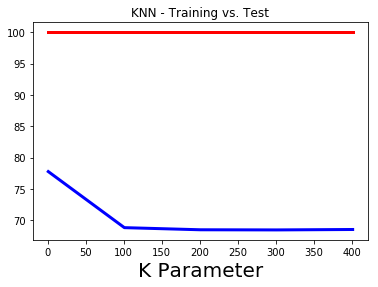

In [615]:
#Find best params - Attendance
tuned_params('KNN', X1, Y1)

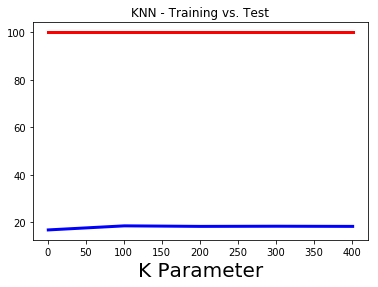

In [616]:
#Find best params - Day of Week
tuned_params('KNN', X2, Y2)

In [617]:
#Run Attendance Model
KNN_Model(5, 'uniform', X1, Y1)


 Percentage accuracy for K Nearest Neighbors Classifier
90.31313358864608%

 Cross-Validation Score
[0.76741573 0.78852643 0.73957159 0.78354002 0.75846501]

 Confusion Matrix


array([[1602,   88,    1,   30],
       [ 103, 1706,   39,    1],
       [   8,   84,  165,    0],
       [  76,    0,    0,  536]])



 Program Executed in 0.15


In [618]:
#Run Day of Week Model
KNN_Model(100, 'uniform', X2, Y2)


 Percentage accuracy for K Nearest Neighbors Classifier
22.707817075917998%

 Cross-Validation Score
[0.18967452 0.19797525 0.16666667 0.17042889 0.17966102]

 Confusion Matrix


array([[215,   7, 235, 134,  10,  53,  86],
       [ 91,  14, 133,  87,   8,  51,  75],
       [155,   5, 337, 127,   6,  53,  70],
       [149,   7, 263, 200,   6,  49,  77],
       [109,   6, 111,  82,   8,  66,  79],
       [142,  16, 155, 117,  10,  94,  94],
       [129,   6, 177, 108,   8,  79, 140]])



 Program Executed in 0.39


**Random Forest Classification**

In [619]:
#Create function

def RFC_Model(trees, ModX, ModY):
    import timeit
    start = timeit.default_timer()
    rfc = ensemble.RandomForestClassifier(n_estimators=trees)
    rfc.fit(ModX, ModY)
    positive_pred = rfc.predict(ModX)
    print('\n Percentage accuracy for Random Forest Classifier')
    print(str(rfc.score(ModX, ModY)*100) + '%')
    print('\n Cross-Validation Score')
    print(cross_val_score(rfc, ModX, ModY, cv=5))
    print('\n Confusion Matrix')
    display(confusion_matrix(ModY, positive_pred))
    
    #Print time
    stop = timeit.default_timer()
    execution_time = stop - start
    print("\n\n Program Executed in {}".format(round(execution_time, 2)))

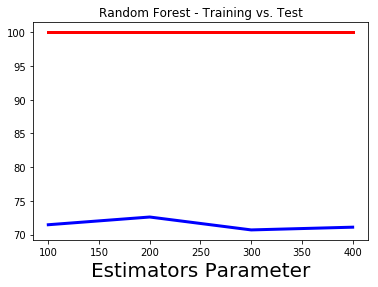

In [620]:
#Find best params - Attendance
tuned_params('Random Forest', X1, Y1)

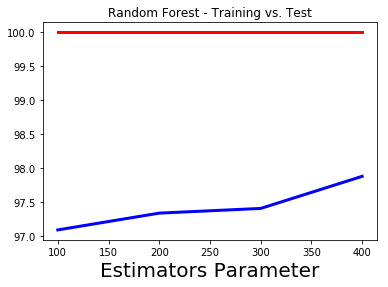

In [621]:
#Find best params - Day of Week
tuned_params('Random Forest', X2, Y2)

In [622]:
#Run Attendance Model
RFC_Model(200, X1, Y1)


 Percentage accuracy for Random Forest Classifier
100.0%

 Cross-Validation Score
[0.31685393 0.82564679 0.85569335 0.80721533 0.79119639]

 Confusion Matrix


array([[1721,    0,    0,    0],
       [   0, 1849,    0,    0],
       [   0,    0,  257,    0],
       [   0,    0,    0,  612]])



 Program Executed in 7.94


In [623]:
#Run Day of Week Model
RFC_Model(300, X2, Y2)


 Percentage accuracy for Random Forest Classifier
100.0%

 Cross-Validation Score
[0.9674523  0.97975253 0.98198198 0.9785553  0.97514124]

 Confusion Matrix


array([[740,   0,   0,   0,   0,   0,   0],
       [  0, 459,   0,   0,   0,   0,   0],
       [  0,   0, 753,   0,   0,   0,   0],
       [  0,   0,   0, 751,   0,   0,   0],
       [  0,   0,   0,   0, 461,   0,   0],
       [  0,   0,   0,   0,   0, 628,   0],
       [  0,   0,   0,   0,   0,   0, 647]])



 Program Executed in 13.03


**Gradient Boosting Classification**

In [624]:
#Create function

def Gradient_Boost_Model(estimators, depth, loss_function, ModX, ModY):
    import timeit
    start = timeit.default_timer()
    clf = ensemble.GradientBoostingClassifier(n_estimators=estimators, max_depth=depth, loss=loss_function)
    clf.fit(ModX, ModY)
    positive_pred = clf.predict(ModX)
    print('\n Percentage accuracy for Gradient Boosting Classifier')
    print(str(clf.score(ModX, ModY)*100) + '%')
    print('\n Cross-Validation Score')
    print(cross_val_score(clf, ModX, ModY, cv=5))
    print('\n Confusion Matrix')
    display(confusion_matrix(ModY, positive_pred))
    
    #Print time
    stop = timeit.default_timer()
    execution_time = stop - start
    print("\n\n Program Executed in {}".format(round(execution_time, 2)))

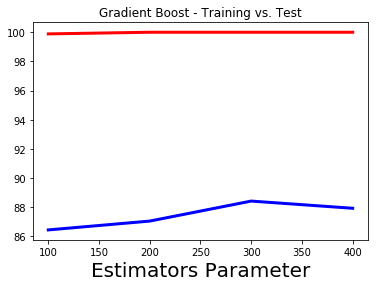

In [625]:
#Find best params - Attendance
tuned_params('GB', X1, Y1)

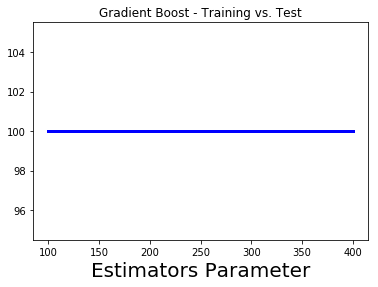

In [626]:
#Find best params - Day of Week
tuned_params('GB', X2, Y2)

In [627]:
#Run Attendance Model
Gradient_Boost_Model(200, 3, 'deviance', X1, Y1)


 Percentage accuracy for Gradient Boosting Classifier
100.0%

 Cross-Validation Score
[0.78988764 0.90663667 0.89853439 0.89289741 0.86681716]

 Confusion Matrix


array([[1721,    0,    0,    0],
       [   0, 1849,    0,    0],
       [   0,    0,  257,    0],
       [   0,    0,    0,  612]])



 Program Executed in 23.29


In [628]:
#Run Day of Week Model
Gradient_Boost_Model(200, 3, 'deviance', X2, Y2)


 Percentage accuracy for Gradient Boosting Classifier
100.0%

 Cross-Validation Score
[1. 1. 1. 1. 1.]

 Confusion Matrix


array([[740,   0,   0,   0,   0,   0,   0],
       [  0, 459,   0,   0,   0,   0,   0],
       [  0,   0, 753,   0,   0,   0,   0],
       [  0,   0,   0, 751,   0,   0,   0],
       [  0,   0,   0,   0, 461,   0,   0],
       [  0,   0,   0,   0,   0, 628,   0],
       [  0,   0,   0,   0,   0,   0, 647]])



 Program Executed in 14.41


**Logistic Regression**

In [629]:
def Logistic_Reg_Model(regularization, alpha, ModX, ModY):
    import timeit
    start = timeit.default_timer()
    if regularization == 'l2' and alpha == 1e9:
        lr_regular = LogisticRegression(penalty=regularization, C=alpha, multi_class='multinomial', solver='lbfgs')
        lr_regular.fit(ModX, ModY)
        positive_pred = lr_regular.predict(ModX)
        print('\n Percentage accuracy for Logistic Regression')
        print(str(lr_regular.score(ModX, ModY)*100) + '%')
        print('\n Cross-Validation Score')
        print(cross_val_score(lr_regular, ModX, ModY, cv=5))
        print('\n Confusion Matrix')
        display(confusion_matrix(ModY, positive_pred))
        
    else:
        lr_ridge = LogisticRegression(penalty=regularization, C=alpha, multi_class='multinomial', solver='lbfgs')
        lr_ridge.fit(ModX, ModY)
        positive_pred = lr_ridge.predict(ModX)
        print('\n Percentage accuracy for Ridge Logistic Regression')
        print(str(lr_ridge.score(ModX, ModY)*100) + '%')
        print('\n Cross-Validation Score')
        print(cross_val_score(lr_ridge, ModX, ModY, cv=5))
        print('\n Confusion Matrix')
        display(confusion_matrix(ModY, positive_pred))
        
     #Print time
    stop = timeit.default_timer()
    execution_time = stop - start
    print("\n\n Program Executed in {}".format(round(execution_time, 2)))

In [630]:
#Run Attendance Model
Logistic_Reg_Model('l2', 1e9, X1, Y1)


 Percentage accuracy for Logistic Regression
99.41428249605767%

 Cross-Validation Score
[0.91235955 0.98987627 0.9481398  0.93799324 0.93115124]

 Confusion Matrix


array([[1715,    1,    0,    5],
       [   4, 1837,    8,    0],
       [   0,    5,  252,    0],
       [   3,    0,    0,  609]])



 Program Executed in 1.11


In [631]:
#Run day of week model
Logistic_Reg_Model('l2', 1e9, X2, Y2)


 Percentage accuracy for Logistic Regression
22.07704437936472%

 Cross-Validation Score
[0.1986532  0.24184477 0.20608108 0.21331828 0.20903955]

 Confusion Matrix


array([[126,   0, 311,  71,   0,   0, 232],
       [ 47,   0, 150,  29,   0,   0, 233],
       [108,   0, 439,  92,   0,   0, 114],
       [141,   0, 336,  83,   0,   0, 191],
       [ 51,   0, 149,  42,   0,   0, 219],
       [ 76,   0, 170,  43,   0,   0, 339],
       [ 87,   0, 175,  53,   0,   0, 332]])



 Program Executed in 1.5


**Ridge Logistic Regression (multiclass)**


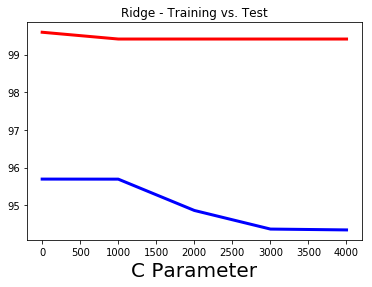

In [632]:
#Find best params - attendance
tuned_params('Ridge', X1, Y1)

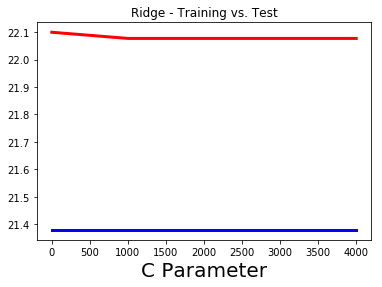

In [633]:
#Find best params - day of week
tuned_params('Ridge', X2, Y2)

In [634]:
#Run Attendance Model
Logistic_Reg_Model('l2', 1.0, X1, Y1)


 Percentage accuracy for Ridge Logistic Regression
99.59450326650146%

 Cross-Validation Score
[0.96404494 0.98537683 0.97632469 0.9210823  0.93792325]

 Confusion Matrix


array([[1718,    2,    0,    1],
       [   3, 1841,    5,    0],
       [   0,    2,  255,    0],
       [   5,    0,    0,  607]])



 Program Executed in 1.27


In [635]:
#Run Day of Week Model
Logistic_Reg_Model('l2', 1.0, X2, Y2)


 Percentage accuracy for Ridge Logistic Regression
22.099571975670194%

 Cross-Validation Score
[0.1986532  0.24184477 0.20608108 0.21331828 0.20903955]

 Confusion Matrix


array([[126,   0, 311,  71,   0,   0, 232],
       [ 46,   0, 150,  29,   0,   0, 234],
       [108,   0, 439,  92,   0,   0, 114],
       [140,   0, 336,  83,   0,   0, 192],
       [ 51,   0, 149,  42,   0,   0, 219],
       [ 76,   0, 170,  43,   0,   0, 339],
       [ 86,   0, 175,  53,   0,   0, 333]])



 Program Executed in 1.48


**Support Vector Classification**

In [636]:
#Create function

def SVC_Model(c, kernel_type, ModX, ModY):
    import timeit
    start = timeit.default_timer()
    svm = SVC(C=c, kernel=kernel_type)
    svm.fit(ModX, ModY)
    positive_pred = svm.predict(ModX)
    print('\n Percentage accuracy for SVM')
    print(str(svm.score(ModX, ModY)*100) + '%')
    print('\n Cross-Validation Score')
    print(cross_val_score(svm, ModX, ModY, cv=5))
    print('\n Confusion Matrix')
    display(confusion_matrix(ModY, positive_pred))
    
    #Print time
    stop = timeit.default_timer()
    execution_time = stop - start
    print("\n\n Program Executed in {}".format(round(execution_time, 2)))

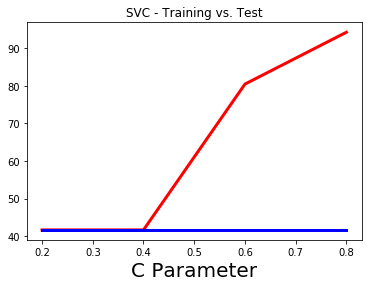

In [637]:
#Find best params - Attendance
tuned_params('SVC', X1, Y1)

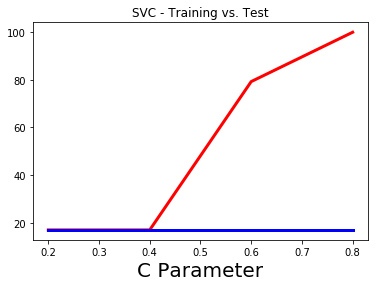

In [638]:
#Find best params - Day of Week
tuned_params('SVC', X2, Y2)

In [639]:
#Run Attendance Model
SVC_Model(0.2, 'rbf', X1, Y1)


 Percentage accuracy for SVM
41.653525568821806%

 Cross-Validation Score
[0.41573034 0.41619798 0.41713641 0.41713641 0.41647856]

 Confusion Matrix


array([[   0, 1721,    0,    0],
       [   0, 1849,    0,    0],
       [   0,  257,    0,    0],
       [   0,  612,    0,    0]])



 Program Executed in 7.63


In [640]:
#Run Day of Week Model
SVC_Model(0.2, 'rbf', X2, Y2)


 Percentage accuracy for SVM
16.96328001802208%

 Cross-Validation Score
[0.1694725  0.16985377 0.17004505 0.16930023 0.16949153]

 Confusion Matrix


array([[  0,   0, 740,   0,   0,   0,   0],
       [  0,   0, 459,   0,   0,   0,   0],
       [  0,   0, 753,   0,   0,   0,   0],
       [  0,   0, 751,   0,   0,   0,   0],
       [  0,   0, 461,   0,   0,   0,   0],
       [  0,   0, 628,   0,   0,   0,   0],
       [  0,   0, 647,   0,   0,   0,   0]])



 Program Executed in 7.89


## Unsupervised Learning

Explore our data through KMeans Clustering Technique

In [641]:
#Determine number of clusters using elbow plot
X1_norm = normalize(X1)
X2_norm = normalize(X2)

In [642]:
def elbow_curve(ModX):
    
    differences = []
    for k in range(1, 31):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(ModX)
        differences.append(kmeans.inertia_)

    plt.figure(figsize=(15, 5))
    plt.plot(range(1, 31), differences)
    plt.xticks(np.arange(0, 31, 1))
    plt.grid(True)
    plt.title('Clusters Elbow Curve')

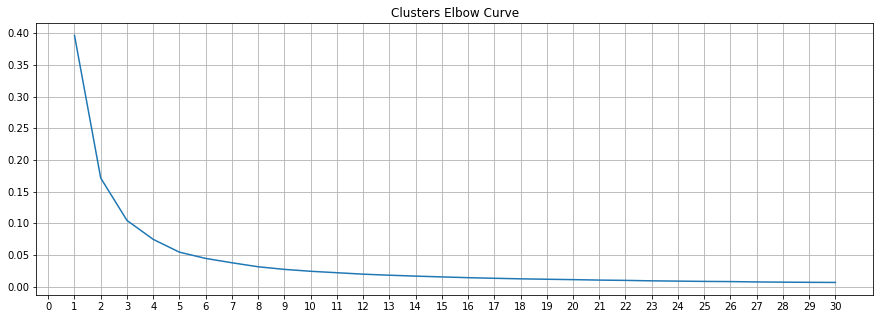

In [643]:
#Run on attendance
elbow_curve(X1_norm)

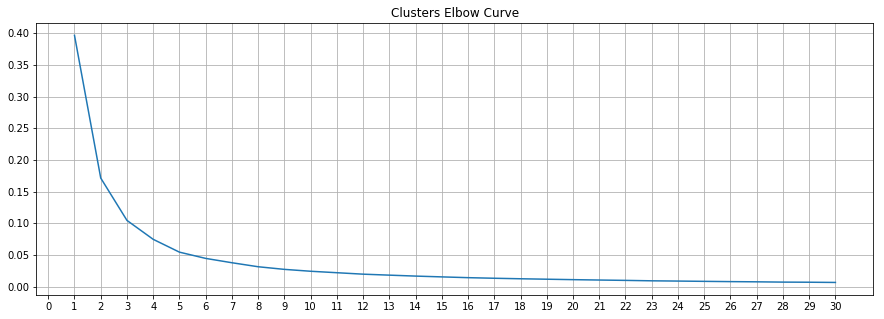

In [644]:
#Run on day of week
elbow_curve(X2_norm)

**KMeans Clustering**

In [645]:
#Create function
def kmeans(clusters, ModX, ModY):
    kmeans_pred = KMeans(n_clusters=clusters).fit_predict(ModX)
    print('Comparing K-Means Clusters for MLB Games:')
    print(pd.crosstab(ModY, kmeans_pred))
    
    #Plot cluster results
    prediction = pd.crosstab(kmeans_pred, ModY)
    prediction.plot(kind='bar', stacked=False, figsize=[20,5])
    plt.title('MLB Games Categorized by KMeans Clusters', fontsize=20)
    plt.xlabel('Cluster', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.xticks(rotation='horizontal')
    plt.show()

Comparing K-Means Clusters for MLB Games:
col_0                        0     1    2
attendance_category_code                 
0                          430  1196   95
1                         1487   350   12
2                          223    34    0
3                            0   208  404


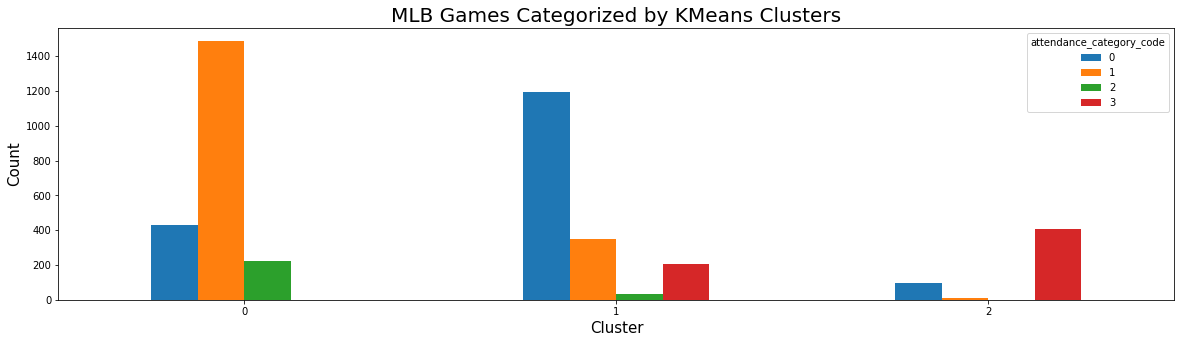

In [656]:
#Run Attendance Model
kmeans(3, X1_norm, Y1)

Comparing K-Means Clusters for MLB Games:
col_0           0    1    2
day_category               
0             402   69  269
1             188   80  191
2             479   33  241
3             408   36  307
4             186   76  199
5             229  111  288
6             248  106  293


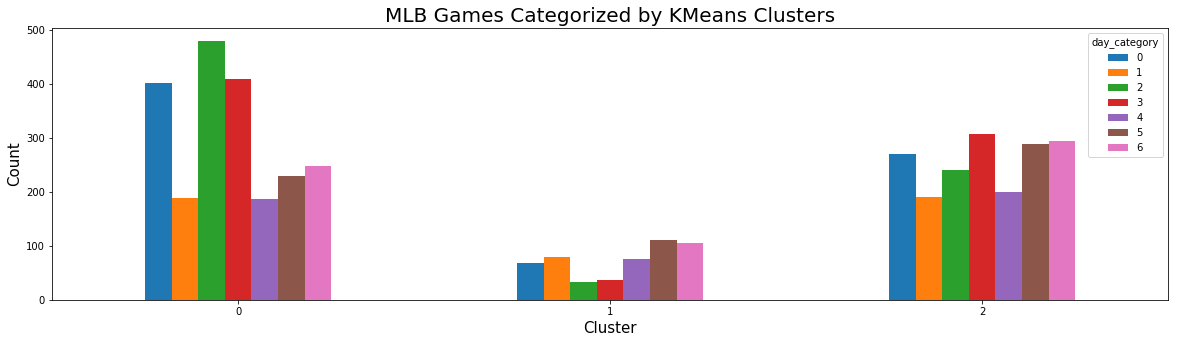

In [647]:
#Run Day of Week Model
kmeans(3, X2_norm, Y2)

## Time Series

In [662]:
#Create dataframes for each year

team_df_2016 = team_df[team_df['year_num'] == 2016]
team_df_2017 = team_df[team_df['year_num'] == 2017]

#Create dataframes for a particular team, for a later exercise
WSN_2016 = team_df_2016[team_df_2016['team'] == 'WSN']
WSN_2017 = team_df_2017[team_df_2017['team'] == 'WSN']

In [669]:
#Use a sample so that our models will run without using too much computing power
team_df_2016 = team_df_2016.sample(n = 250)
team_df_2017 = team_df_2017.sample(n = 250)

#Reset our indices
team_df_2016 = team_df_2016.set_index(team_df_2016.actual_date)
team_df_2017 = team_df_2017.set_index(team_df_2017.actual_date)

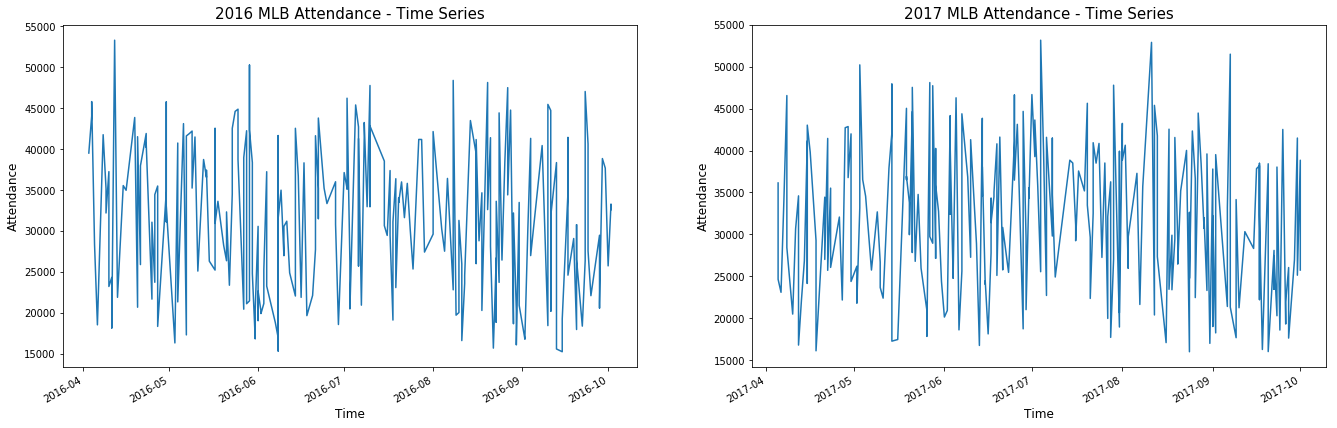

In [687]:
#Let's look at both 2016 and 2017

plt.figure(figsize=[35,7])

plt.subplot(1,3,1)
team_df_2016.attendance.plot()
plt.title('2016 MLB Attendance - Time Series', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Attendance', fontsize=12)

plt.subplot(1,3,2)
team_df_2017.attendance.plot()
plt.title('2017 MLB Attendance - Time Series', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Attendance', fontsize=12)
plt.show()

In [674]:
#Let's look at both 2016 and 2017
from statsmodels.tsa.stattools import pacf

acf_2016 = pd.DataFrame(pacf(team_df_2016.attendance))
acf_2017 = pd.DataFrame(pacf(team_df_2017.attendance))

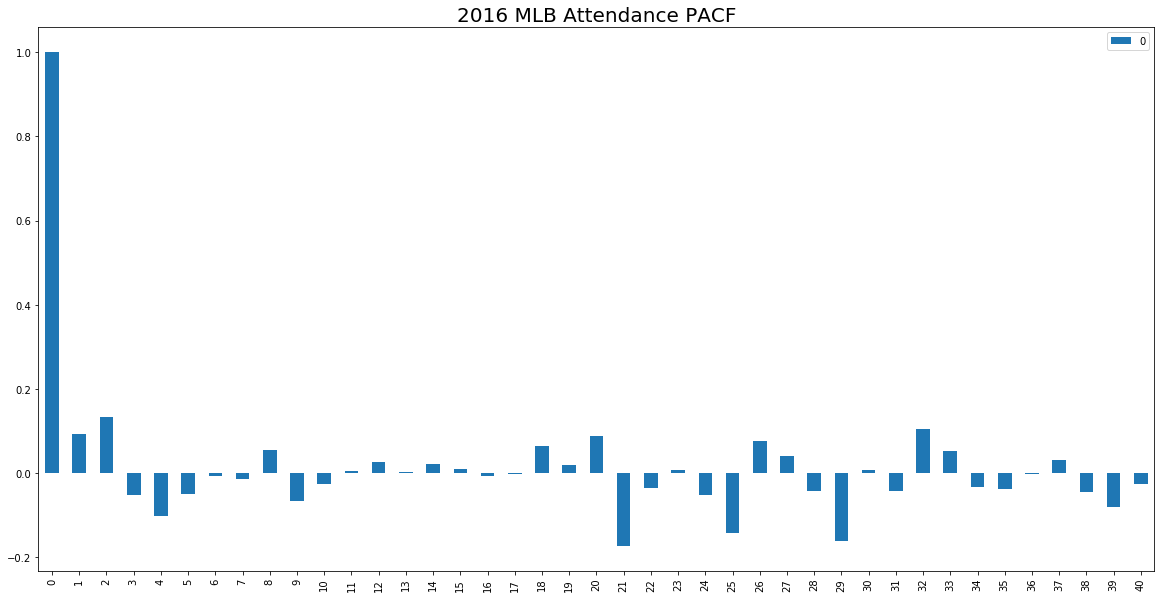

In [678]:
#Plot 2016
acf_2016.plot(kind='bar', figsize=(20, 10))
plt.title("2016 MLB Attendance PACF", fontsize=20)
plt.show()

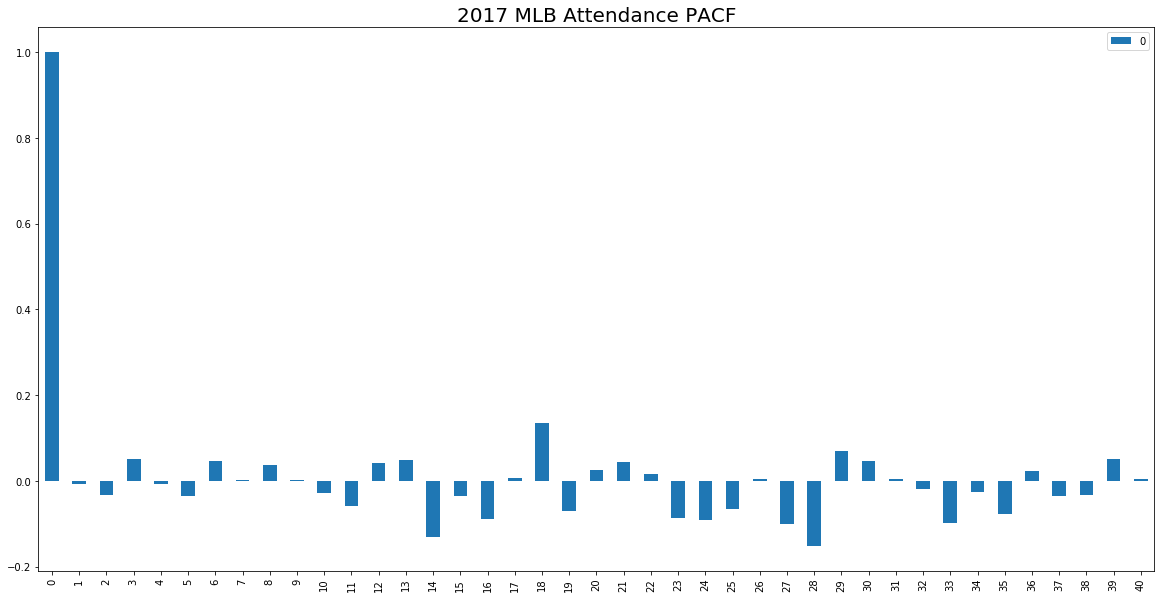

In [679]:
#Plot 2017
acf_2017.plot(kind='bar', figsize=(20, 10))
plt.title("2017 MLB Attendance PACF", fontsize=20)
plt.show()

## Build Models

In [696]:
#Convert attendance to float for purpose of ARMA modeling
team_df_2016['attendance'] = team_df_2016['attendance'].astype(float)
team_df_2017['attendance'] = team_df_2017['attendance'].astype(float)

In [698]:
#using ARMA because data is stationary and did not need to use differencing
from statsmodels.tsa.arima_model import ARMA

def ARMA_model(data, AR, MA):
    model = ARMA(data, order=(AR,MA))
    model_fit = model.fit()
    print(model_fit.summary())
    print('Residuals Description for AR({}) and MA({})'.format(AR, MA))
    print(model_fit.resid.describe())

**First, begin with 2016**

In [699]:
ARMA_model(team_df_2016.attendance, 1, 0)

                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                  250
Model:                     ARMA(1, 0)   Log Likelihood               -2628.297
Method:                       css-mle   S.D. of innovations           8903.804
Date:                Mon, 06 Aug 2018   AIC                           5262.595
Time:                        14:34:41   BIC                           5273.159
Sample:                    04-09-2016   HQIC                          5266.847
                         - 04-19-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.161e+04    620.013     50.989      0.000    3.04e+04    3.28e+04
ar.L1.attendance     0.0921      0.063      1.459      0.146      -0.032       0.216
                            

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [701]:
ARMA_model(team_df_2016.attendance, 2, 1)

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                  250
Model:                     ARMA(2, 1)   Log Likelihood               -2625.961
Method:                       css-mle   S.D. of innovations           8820.324
Date:                Mon, 06 Aug 2018   AIC                           5261.923
Time:                        14:35:52   BIC                           5279.530
Sample:                    04-09-2016   HQIC                          5269.009
                         - 04-19-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.163e+04    696.823     45.390      0.000    3.03e+04     3.3e+04
ar.L1.attendance    -0.0746      0.312     -0.239      0.811      -0.686       0.537
ar.L2.attendance     0.1492 

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [702]:
ARMA_model(team_df_2016.attendance, 2, 2)

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                  250
Model:                     ARMA(2, 2)   Log Likelihood               -2624.438
Method:                       css-mle   S.D. of innovations           8764.075
Date:                Mon, 06 Aug 2018   AIC                           5260.876
Time:                        14:39:10   BIC                           5282.005
Sample:                    04-09-2016   HQIC                          5269.380
                         - 04-19-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.161e+04    627.066     50.415      0.000    3.04e+04    3.28e+04
ar.L1.attendance     0.9798      0.181      5.413      0.000       0.625       1.335
ar.L2.attendance    -0.8045 

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [708]:
ARMA_model(team_df_2016.attendance, 0, 2)

                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                  250
Model:                     ARMA(0, 2)   Log Likelihood               -2625.484
Method:                       css-mle   S.D. of innovations           8803.250
Date:                Mon, 06 Aug 2018   AIC                           5258.969
Time:                        14:41:10   BIC                           5273.055
Sample:                    04-09-2016   HQIC                          5264.638
                         - 04-19-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.161e+04    694.758     45.503      0.000    3.03e+04     3.3e+04
ma.L1.attendance     0.0829      0.062      1.339      0.182      -0.038       0.204
ma.L2.attendance     0.1666 

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


**Now, analyze 2017**

In [710]:
ARMA_model(team_df_2017.attendance, 2, 1)

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                  250
Model:                     ARMA(2, 1)   Log Likelihood               -2625.170
Method:                       css-mle   S.D. of innovations           8793.181
Date:                Mon, 06 Aug 2018   AIC                           5260.340
Time:                        14:42:39   BIC                           5277.947
Sample:                    05-19-2017   HQIC                          5267.426
                         - 09-17-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.206e+04    536.285     59.787      0.000     3.1e+04    3.31e+04
ar.L1.attendance    -0.4083      0.587     -0.695      0.487      -1.559       0.742
ar.L2.attendance    -0.0453 

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [712]:
ARMA_model(team_df_2017.attendance, 3, 2)

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                  250
Model:                     ARMA(3, 2)   Log Likelihood               -2622.082
Method:                       css-mle   S.D. of innovations           8620.006
Date:                Mon, 06 Aug 2018   AIC                           5258.164
Time:                        14:43:08   BIC                           5282.814
Sample:                    05-19-2017   HQIC                          5268.085
                         - 09-17-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.207e+04    546.669     58.656      0.000     3.1e+04    3.31e+04
ar.L1.attendance    -1.0494      0.065    -16.264      0.000      -1.176      -0.923
ar.L2.attendance    -1.0008 

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [716]:
ARMA_model(team_df_2017.attendance, 5, 3)

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

                              ARMA Model Results                              
Dep. Variable:             attendance   No. Observations:                  250
Model:                     ARMA(5, 3)   Log Likelihood               -2621.380
Method:                       css-mle   S.D. of innovations           8594.806
Date:                Mon, 06 Aug 2018   AIC                           5262.760
Time:                        14:44:29   BIC                           5297.974
Sample:                    05-19-2017   HQIC                          5276.933
                         - 09-17-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.244e+04    192.302    168.674      0.000    3.21e+04    3.28e+04
ar.L1.attendance    -0.0574      0.066     -0.875      0.382      -0.186       0.071
ar.L2.attendance     0.0375 

/Users/str/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


## Final Analysis and Results